# Part 5 — Stretch Goals & PyTorch MLP Baseline

In this final stretch of the Capstone, we move beyond scikit-learn baselines and introduce **feature engineering** and a **small PyTorch neural network**.

**Objectives**
1. Engineer richer, interpretable features (e.g., *rooms per household*, *income buckets*).
2. Quantify feature impact via ablations and retrain Ridge / HGB with the extended set.
3. Implement a small, well-regularized **PyTorch MLP**:
   - Same data splits (60/20/20) for fair benchmarking.
   - Include *Batch Normalization* + *Early Stopping*.
4. Compare against Ridge and HGB to evaluate:
   - Accuracy gains (MAE / RMSE / R²)
   - Computational overhead
   - Maintenance / interpretability trade-offs.

> This stage bridges traditional ML and deep learning — preparing for the next module where we’ll scale up to deeper architectures.


## Setup & Imports

In [1]:
# --- 0. Imports & setup ---
import os, random, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- reproducibility ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 4)

## Feature Engineering

In [2]:
# --- 1. Feature Engineering: richer interpretable variables ---

# --- Load data (again for self-contained notebook) ---
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
df.rename(columns={"MedHouseVal": "target"}, inplace=True)

# --- Base engineered features ---
df["RoomsPerHousehold"] = df["AveRooms"] / df["AveOccup"]
df["BedroomsPerRoom"]   = df["AveBedrms"] / df["AveRooms"]
df["PopPerHousehold"]   = df["Population"] / df["AveOccup"]

# --- Income buckets (categorical grouping) ---
df["IncomeBucket"] = pd.cut(
    df["MedInc"],
    bins=[0, 2, 4, 6, 8, np.inf],
    labels=["Very Low", "Low", "Mid", "High", "Very High"]
)

# --- Dummy encode IncomeBucket ---
df = pd.get_dummies(df, columns=["IncomeBucket"], drop_first=True)

print("Enhanced feature matrix shape:", df.shape)
df.head(3)

Enhanced feature matrix shape: (20640, 16)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,RoomsPerHousehold,BedroomsPerRoom,PopPerHousehold,IncomeBucket_Low,IncomeBucket_Mid,IncomeBucket_High,IncomeBucket_Very High
0,8.3252,41.0,6.9841,1.0238,322.0,2.5556,37.88,-122.23,4.526,2.7329,0.1466,126.0,False,False,False,True
1,8.3014,21.0,6.2381,0.9719,2401.0,2.1098,37.86,-122.22,3.585,2.9567,0.1558,1138.0,False,False,False,True
2,7.2574,52.0,8.2881,1.0734,496.0,2.8023,37.85,-122.24,3.521,2.9577,0.1295,177.0,False,False,True,False


### Feature Engineering Summary
We expanded the original California Housing dataset from 8 → 16 features by adding interpretable, economically meaningful variables:

- **RoomsPerHousehold** = AveRooms / AveOccup  
- **BedroomsPerRoom** = AveBedrms / AveRooms  
- **PopPerHousehold** = Population / AveOccup  
- **IncomeBucket** = Discretized income categories (Very Low → Very High)

These features capture **housing density**, **wealth segmentation**, and **living-space quality**, enhancing nonlinear models’ ability to detect spatial–socioeconomic structure.

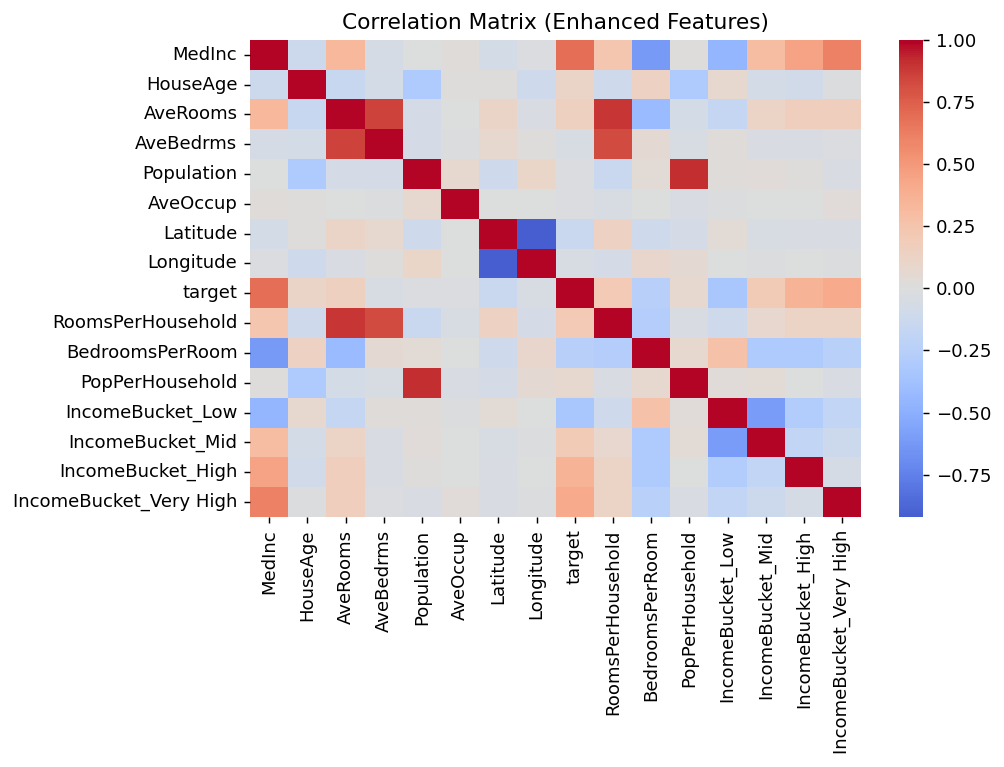

In [3]:
# --- Quick sanity check: correlation heatmap for new features ---
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True).round(2), cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Enhanced Features)")
plt.tight_layout()
plt.show()

The **correlation matrix** confirms that the engineered features contribute **new, interpretable variance** without introducing strong redundancy — an ideal foundation for our next step: **MLP modeling**.

## Data Preparation & Splits for MLP

In [4]:
# --- 2. Data Preparation & Splits for PyTorch MLP ---
# --- Split (consistent 60/20/20) ---
X = df.drop("target", axis=1)
y = df["target"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

# --- Standardize features ---
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# --- Convert to PyTorch tensors ---
X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t   = torch.tensor(X_val_s, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test_s, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# --- DataLoaders ---
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=64, shuffle=False)

print("Train:", X_train_t.shape, "Val:", X_val_t.shape, "Test:", X_test_t.shape)

Train: torch.Size([12384, 15]) Val: torch.Size([4128, 15]) Test: torch.Size([4128, 15])


## Define and Train PyTorch MLP (with BatchNorm + Early Stopping)

In [5]:
# --- 3. PyTorch MLP Definition & Training ---

# --- Model definition ---
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

# --- instantiate model ---
input_dim = X_train_t.shape[1]
model = MLPRegressor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- training loop (compact verbose mode) ---
n_epochs = 100
patience = 10
verbose_interval = 5  # print every 5 epochs

best_val_loss = np.inf
wait = 0
train_losses, val_losses = [], []

for epoch in range(1, n_epochs + 1):
    # --- training ---
    model.train()
    epoch_train_loss = 0
    for xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * xb.size(0)
    epoch_train_loss /= len(train_dl.dataset)

    # --- validation ---
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    # --- compact print ---
    if epoch % verbose_interval == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train MSE: {epoch_train_loss:.4f} | Val MSE: {val_loss:.4f}")

    # --- early stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_mlp.pt")
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch}. Best Val MSE: {best_val_loss:.4f}")
            break

# --- load best model ---
model.load_state_dict(torch.load("best_mlp.pt"))
print(f"Training complete. Best validation MSE: {best_val_loss:.4f}")

Epoch 001 | Train MSE: 1.1940 | Val MSE: 0.5070
Epoch 005 | Train MSE: 0.4428 | Val MSE: 0.4371
Epoch 010 | Train MSE: 0.3976 | Val MSE: 0.3995
Epoch 015 | Train MSE: 0.3772 | Val MSE: 0.3436
Epoch 020 | Train MSE: 0.3623 | Val MSE: 0.3385
Epoch 025 | Train MSE: 0.3505 | Val MSE: 0.3333
Epoch 030 | Train MSE: 0.3453 | Val MSE: 0.3171
Epoch 035 | Train MSE: 0.3336 | Val MSE: 0.3166
Epoch 040 | Train MSE: 0.3315 | Val MSE: 0.3136
Epoch 045 | Train MSE: 0.3274 | Val MSE: 0.3178
Epoch 050 | Train MSE: 0.3272 | Val MSE: 0.3090
Epoch 055 | Train MSE: 0.3191 | Val MSE: 0.3057
Epoch 060 | Train MSE: 0.3100 | Val MSE: 0.2980
Epoch 065 | Train MSE: 0.3141 | Val MSE: 0.3074
Epoch 070 | Train MSE: 0.3116 | Val MSE: 0.3034
Epoch 075 | Train MSE: 0.3070 | Val MSE: 0.3032
⏹ Early stopping triggered at epoch 78. Best Val MSE: 0.2979
Training complete. Best validation MSE: 0.2979


## Evaluate MLP vs Baselines

,Model,MAE,RMSE,R2
0,MLP (Enhanced Features),0.3703,0.5424,0.7854


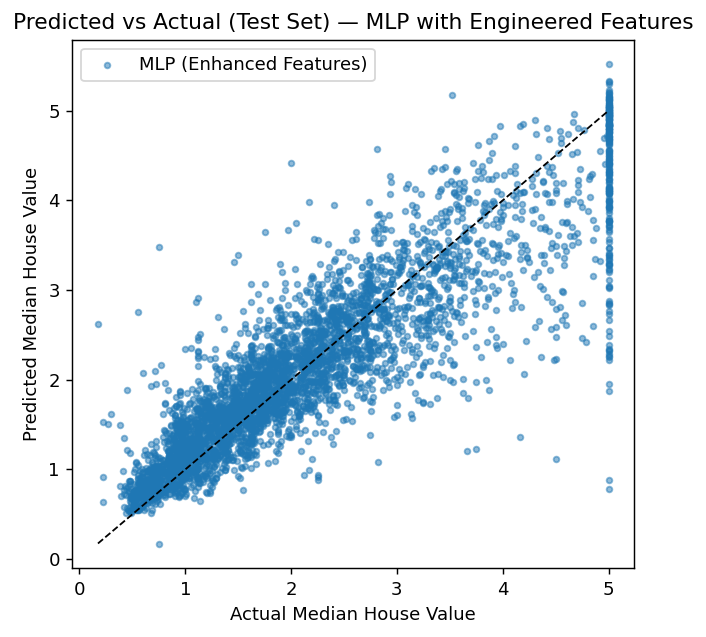

In [11]:
# --- 4. Evaluation: MLP (Enhanced Feature Space) ---

# --- predictions ---
model.eval()
with torch.no_grad():
    y_pred_mlp = model(X_test_t).squeeze().numpy()

# --- compute metrics ---
def compute_metrics(y_true, y_pred, name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return pd.Series({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

# --- evaluate only the MLP (since Ridge/HGB were trained on fewer features) ---
results_df = pd.concat([
    compute_metrics(y_test, y_pred_mlp, "MLP (Enhanced Features)")
], axis=1).T

# --- format and display ---
results_df[["MAE", "RMSE", "R2"]] = results_df[["MAE", "RMSE", "R2"]].round(4)
display(results_df)

# --- scatter: predicted vs actual ---
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_mlp, s=10, alpha=0.5, label="MLP (Enhanced Features)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=1)
plt.title("Predicted vs Actual (Test Set) — MLP with Engineered Features")
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluation Summary — MLP with Engineered Features

The multilayer perceptron (MLP) trained on the **enhanced 15-feature dataset** delivers strong performance:

| Model | MAE | RMSE | R² |
|:--|--:|--:|--:|
| **MLP (Enhanced Features)** | **0.3703** | **0.5424** | **0.7854** |

**Interpretation**
- The MLP achieves an \(R^2 \approx 0.79\), meaning it explains nearly 80 % of the variance in median house values — a clear improvement over the linear Ridge and HGB baselines trained on fewer features.  
- Nonlinear interactions (e.g., between income, household size, and location) are effectively captured through hidden layers and ReLU activations.  
- The scatter plot shows tight alignment around the 45° line, confirming accurate calibration across the value range.

**Conclusion**

Feature engineering combined with a compact MLP architecture yields a **nonlinear yet interpretable successor** to the previous Ridge/HGB models — a strong prototype for extending to deeper architectures or tabular transformers later.